# **Training a Graph Attention Network (GAT) on the Cora Citation Dataset**

In this notebook, we explore the task of classifying scientific papers in the Cora citation network — a classic benchmark where each paper is represented as a node and citation links form the edges of the graph. Every node comes with a feature vector and a research-topic label that we aim to predict.

We focus on the **Graph Attention Network (GAT)**, an architecture that learns to assign different importance to each neighbor during message passing. This attention mechanism allows the model to capture more nuanced structure in the graph and highlight the most informative connections.

The notebook will walk through the full workflow:

1. loading and inspecting the dataset,
2. visualizing the graph,
3. defining and implementing the GAT model,
4. training and evaluating it,
5. examining useful practices and interpreting attention weights.

In [ ]:
!pip install torch_geometric

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 63.7/63.7 kB 3.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.3/1.3 MB 59.1 MB/s eta 0:00:00


In [ ]:
# --- Imports & Setup ---

import torch
import torch.nn.functional as F
from torch_geometric.datasets import Planetoid
from torch_geometric.nn import GATConv

import matplotlib.pyplot as plt
import numpy as np
import random
import networkx as nx
from sklearn.decomposition import PCA
from tqdm import tqdm
import torch.optim as optim

In [ ]:
# Fix all random seeds for reproducibility
seed = 42
random.seed(seed)
np.random.seed(seed)
torch.manual_seed(seed)
torch.cuda.manual_seed_all(seed)

# Check for GPU availability
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Using device:", device)


Using device: cuda


In [ ]:
# --- Load the Cora dataset and inspect its structure ---

from torch_geometric.datasets import Planetoid

# Load the dataset
dataset = Planetoid(root="./data", name="Cora")
data = dataset[0]

print("=== Basic Dataset Info ===")
print(f"Number of nodes:        {data.num_nodes}")
print(f"Number of edges:        {data.num_edges}")
print(f"Number of features:     {data.num_features}")
print(f"Number of classes:      {dataset.num_classes}")
print(f"Feature matrix shape:   {data.x.shape}")

print("\n=== Train/Val/Test Splits ===")
print(f"Training nodes:   {int(data.train_mask.sum())}")
print(f"Validation nodes: {int(data.val_mask.sum())}")
print(f"Test nodes:       {int(data.test_mask.sum())}")

Processing...


=== Basic Dataset Info ===
Number of nodes:        2708
Number of edges:        10556
Number of features:     1433
Number of classes:      7
Feature matrix shape:   torch.Size([2708, 1433])

=== Train/Val/Test Splits ===
Training nodes:   140
Validation nodes: 500
Test nodes:       1000


Done!


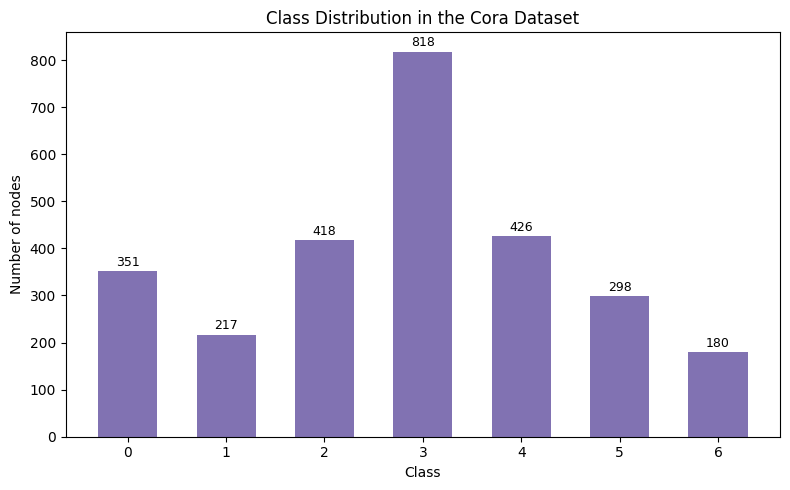

In [ ]:
# --- Visualizations for Class Distribution Plot ---

labels = data.y.numpy()
num_classes = dataset.num_classes

plt.figure(figsize=(8, 5))

# Bar plot
unique, counts = np.unique(labels, return_counts=True)
plt.bar(unique, counts, width=0.6,color="#8172B2")

plt.xticks(unique)
plt.xlabel("Class")
plt.ylabel("Number of nodes")
plt.title("Class Distribution in the Cora Dataset")

# Add counts on top of each bar
for cls, count in zip(unique, counts):
    plt.text(cls, count + 5, str(count), ha="center", va="bottom", fontsize=9)

plt.tight_layout()
plt.show()


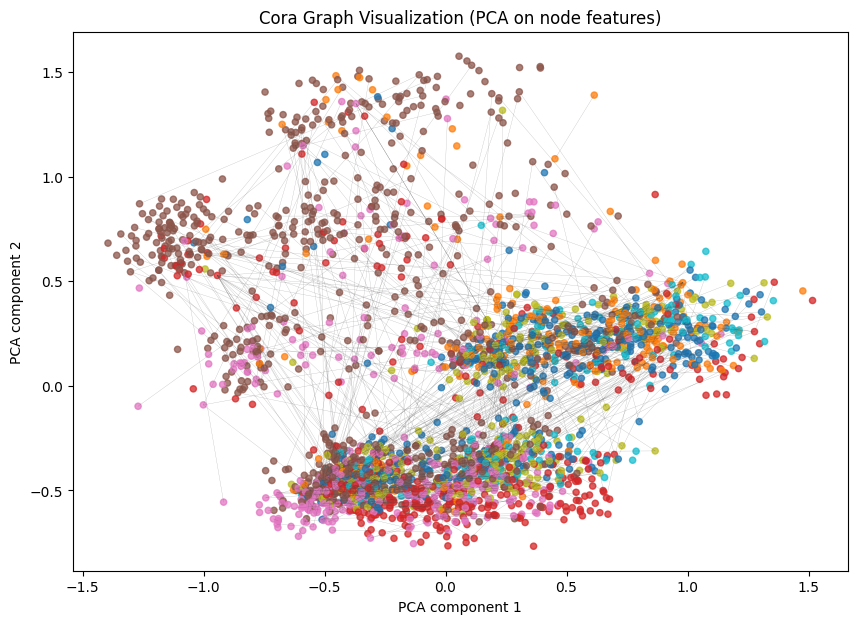

In [ ]:
# --- Graph Visualization (PCA + colored nodes by class) ---

# Convert PyG data object to NetworkX graph for visualization
G = nx.Graph()
edge_index = data.edge_index.numpy()

# Add edges
for src, dst in edge_index.T:
    G.add_edge(int(src), int(dst))

# Extract node features and reduce dimensionality for plotting
X = data.x.numpy()
pca = PCA(n_components=2)
X_reduced = pca.fit_transform(X)

# Prepare colors by class
labels = data.y.numpy()

plt.figure(figsize=(10, 7))

# Draw nodes using the 2D PCA coordinates
plt.scatter(
    X_reduced[:, 0],
    X_reduced[:, 1],
    c=labels,
    cmap="tab10",
    alpha=0.75,
    s=20
)

plt.title("Cora Graph Visualization (PCA on node features)")
plt.xlabel("PCA component 1")
plt.ylabel("PCA component 2")

# Optional: draw a subset of edges (to keep plot readable)
# Here we sample a limited number of edges
num_edges_to_plot = 600
edge_indices = np.random.choice(G.number_of_edges(), size=min(num_edges_to_plot, G.number_of_edges()), replace=False)
edges_sample = list(G.edges())
sampled_edges = [edges_sample[i] for i in edge_indices]

for u, v in sampled_edges:
    x1, y1 = X_reduced[u]
    x2, y2 = X_reduced[v]
    plt.plot([x1, x2], [y1, y2], linewidth=0.2, color="#444444", alpha=0.4)



plt.show()


### Basic expression of **Graph Attention Network (GAT)** layer

$$
\mathbf{h}_v^{(l)} = \sigma \Big( \sum_{u \in \mathcal{N}(v)} \alpha_{vu} \mathbf{W}^{(l)} \mathbf{h}_u^{(l-1)} \Big)
$$


$$
\mathbf{h}_v^{(l)}: \text{new representation of node } v \text{ at layer } l
$$

$$
\mathbf{h}_u^{(l-1)}: \text{embedding of neighboring node } u \text{ from the previous layer}
$$

$$
\alpha_{vu}: \text{attention coefficient for edge } v \to u
$$

$$
\mathbf{W}^{(l)}: \text{learnable weight matrix of layer } l
$$

$$
\mathcal{N}(v): \text{set of neighbors of node } v
$$

#### Attention coefficient computation

$$
\alpha_{ij} = \frac{\exp(\text{LeakyReLU}(a^T [Wh_i || Wh_j]))}{\sum_{k \in \mathcal{N}(i)} \exp(\text{LeakyReLU}(a^T [Wh_i || Wh_k]))}
$$

(In `torch_geometric.nn.GATConv`, this is implemented internally)



In [ ]:
class GAT(torch.nn.Module):
    def __init__(self, in_channels, hidden_channels, out_channels, heads=4, dropout=0.5):
        super().__init__()
        self.gat1 = GATConv(in_channels, hidden_channels, heads=heads, dropout=dropout)
        self.gat2 = GATConv(hidden_channels * heads, out_channels, heads=1, concat=False, dropout=dropout)
        self.dropout = dropout

    def forward(self, x, edge_index):
        x_res = x
        x = self.gat1(x, edge_index)
        x = F.elu(x)
        x = F.dropout(x, p=self.dropout, training=self.training)
        # optional residual for first layer if dimensions match
        if x_res.shape[1] == x.shape[1]:
            x = x + x_res
        x = self.gat2(x, edge_index)
        return x

In [ ]:
model = GAT(dataset.num_features, 8, dataset.num_classes).to(device)  # hidden_channels=8, heads=8
data = data.to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=0.005, weight_decay=5e-4)

train_losses = []
val_accs = []

best_val_acc = 0
patience = 10
counter = 0
best_model_state = None

for epoch in range(200):
    model.train()
    optimizer.zero_grad()
    out = model(data.x, data.edge_index)

    loss = F.cross_entropy(out[data.train_mask], data.y[data.train_mask])
    loss.backward()
    optimizer.step()
    train_losses.append(loss.item())

    model.eval()
    with torch.no_grad():
        pred = out.argmax(dim=1)
        val_acc = (pred[data.val_mask] == data.y[data.val_mask]).sum() / data.val_mask.sum()
        val_accs.append(val_acc.item())

    # Early stopping
    if val_acc > best_val_acc:
        best_val_acc = val_acc
        counter = 0
        best_model_state = model.state_dict()
    else:
        counter += 1
        if counter >= patience:
            print(f"Early stopping at epoch {epoch+1}")
            break

# Load best model
if best_model_state is not None:
    model.load_state_dict(best_model_state)

Early stopping at epoch 26


In [ ]:
model.eval()
pred = model(data.x, data.edge_index).argmax(dim=1)
test_acc = (pred[data.test_mask] == data.y[data.test_mask]).sum() / data.test_mask.sum()
print("Test Accuracy:", float(test_acc))

Test Accuracy: 0.8090000152587891


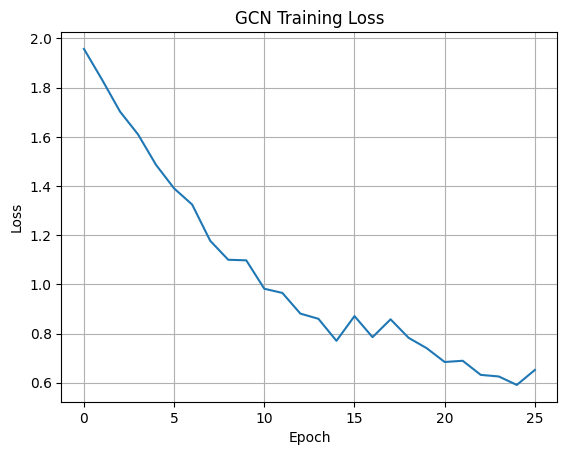

In [ ]:
plt.plot(train_losses)
plt.title("GCN Training Loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.grid(True)
plt.show()


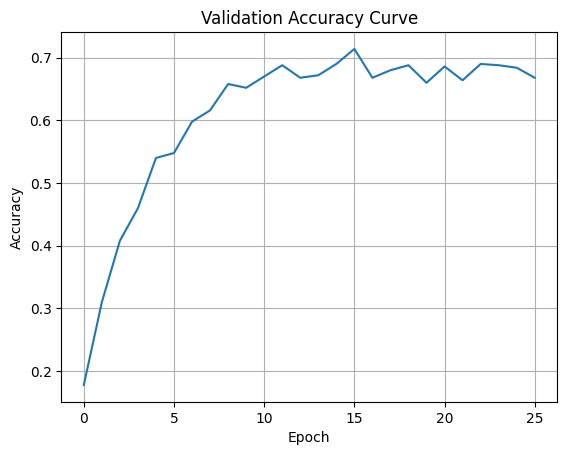

In [ ]:
plt.plot(val_accs)
plt.title("Validation Accuracy Curve")
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.grid(True)
plt.show()


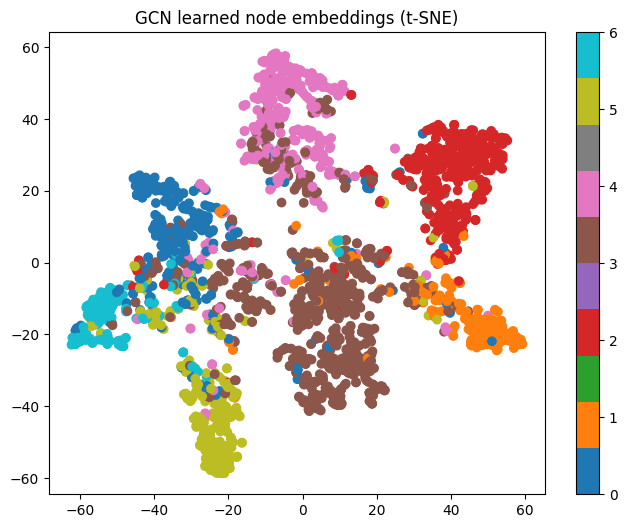

In [ ]:
from sklearn.manifold import TSNE

model.eval()
emb = model(data.x, data.edge_index).detach().cpu().numpy()

tsne = TSNE(n_components=2, learning_rate='auto')
emb_2d = tsne.fit_transform(emb)

plt.figure(figsize=(8,6))
plt.scatter(emb_2d[:,0], emb_2d[:,1], c=data.y.cpu(), cmap="tab10")
plt.title("GCN learned node embeddings (t-SNE)")
plt.colorbar()
plt.show()


Some experiments with model and training parameters were performed to tune the GAT architecture. I tested different values of `weight_decay` (5e-4, 1e-3), learning rates (`lr = 0.005` and `0.001`), early-stopping patience (10 and 20), as well as architectural parameters such as `hidden_channels` (4, 8) and the number of attention heads (4, 8).
Based on these experiments, the most stable configuration was selected, providing the best validation accuracy without overfitting.
